# Gutenberg's books classification

## Merely mounting the google drive folder

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import os
folder_path = "/content/gdrive/MyDrive/NLP - 2024-2/hw04"
os.chdir(folder_path)

## Loading data

In [3]:
import re, os, random
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import pandas as pd

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def extract_text_between_markers(file_content):
    """Extrae solo el contenido de libro."""
    start_marker = r"\*\*\* START OF THE PROJECT GUTENBERG EBOOK"
    end_marker = r"\*\*\* END OF THE PROJECT GUTENBERG EBOOK"

    start_idx = re.search(start_marker, file_content)
    end_idx = re.search(end_marker, file_content)

    if start_idx and end_idx:
        return file_content[start_idx.end():end_idx.start()]
    return None

def preprocess_text(text):
    """Preprocesa el texto extraído."""
    # Convierte a minúsculas
    text = text.lower()

    # Elimina la puntuación (deja solo palabras y espacios)
    text = re.sub(r'[^\w\s]', '', text)

    # Tokeniza por espacios
    tokens = text.split()

    # Elimina stopwords y palabras de menos de 3 caracteres
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Lematiza los tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

In [5]:
def load_and_preprocess_books(directory):
    """Carga y preprocesa los libros de los tres autores."""
    authors_data = {}
    authors = os.listdir(directory)

    for author in authors:
        author_path = os.path.join(directory, author)
        if os.path.isdir(author_path):
            all_books_text = []
            for book_file in os.listdir(author_path):
                if book_file.endswith('.txt'):
                    book_path = os.path.join(author_path, book_file)
                    with open(book_path, 'r', encoding='utf-8') as f:
                        file_content = f.read()

                    extracted_text = extract_text_between_markers(file_content)

                    if extracted_text:
                        tokens = preprocess_text(extracted_text)
                        text = " ".join(tokens)

                        # Segmenta el texto en chunks de 250 palabras, con superposiciones.
                        word_chunks = [text[i:i+250] for i in range(0, len(text.split()), 200)]
                        all_books_text.extend(word_chunks)

            authors_data[author] = all_books_text

    return authors_data


def split_dataset(authors_data, test_size=0.15, val_size=0.15):
    train_data, val_data, test_data = [], [], []

    for author, texts in authors_data.items():
        train_texts, temp_texts = train_test_split(texts, test_size=(val_size + test_size), random_state=42)
        val_texts, test_texts = train_test_split(temp_texts, test_size=(test_size / (val_size + test_size)), random_state=42)

        train_data += [(text, author) for text in train_texts]
        val_data += [(text, author) for text in val_texts]
        test_data += [(text, author) for text in test_texts]

    return train_data, val_data, test_data

def count_classes(data):
    return pd.Series([label for _, label in data]).value_counts()

def summarize_dataset(train_data, val_data, test_data):
    train_summary = count_classes(train_data)
    val_summary = count_classes(val_data)
    test_summary = count_classes(test_data)

    summary_df = pd.DataFrame({
        "Train Samples": train_summary,
        "Validation Samples": val_summary,
        "Test Samples": test_summary
    })

    return summary_df

In [6]:
books_directory = 'books'
authors_data = load_and_preprocess_books(books_directory)
train_data, val_data, test_data = split_dataset(authors_data)
summary_df = summarize_dataset(train_data, val_data, test_data)
summary_df

,Train Samples,Validation Samples,Test Samples
jane_austen,639,137,138
arthur_conan_doyle,322,69,70
edgar_allan_poe,321,69,69


## Building a classifier

In [7]:
from gensim.models import Word2Vec
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_gensim_model(embedding_size):
    model_path = f'models/Books_{embedding_size}.model'
    gensim_model = Word2Vec.load(model_path)
    return gensim_model

def create_embedding_matrix(gensim_model, tokenizer, embedding_size):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_size))

    for word, idx in tokenizer.word_index.items():
        if word in gensim_model.wv:
            embedding_matrix[idx] = gensim_model.wv[word]

    return embedding_matrix

In [8]:
def prepare_text_data(texts, tokenizer, max_length=250):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts([text for text, _ in train_data])
train_sequences = prepare_text_data([text for text, _ in train_data], tokenizer)
val_sequences = prepare_text_data([text for text, _ in val_data], tokenizer)
test_sequences = prepare_text_data([text for text, _ in test_data], tokenizer)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

def create_model_architecture_1(embedding_matrix, vocab_size, embedding_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[embedding_matrix], input_length=250, trainable=False))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

def create_model_architecture_2(embedding_matrix, vocab_size, embedding_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[embedding_matrix], input_length=250, trainable=False))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

def create_model_architecture_3(embedding_matrix, vocab_size, embedding_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[embedding_matrix], input_length=250, trainable=False))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score

def train_model(model, train_data, val_data, model_name, batch_size=32, epochs=20):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    mc = ModelCheckpoint(f'best_model_{model_name}.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    X_train, y_train = train_data
    X_val, y_val = val_data

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es, mc])

    return history

In [11]:
def evaluate_model(model, test_data):
    X_test, y_test = test_data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')

    return accuracy, precision, recall

In [12]:
X_test = prepare_text_data([text for text, _ in test_data], tokenizer)
y_test = pd.get_dummies([label for _, label in test_data]).values

vocab_size = len(tokenizer.word_index) + 1

X_train = prepare_text_data([text for text, _ in train_data], tokenizer)
y_train = pd.get_dummies([label for _, label in train_data]).values
X_val = prepare_text_data([text for text, _ in val_data], tokenizer)
y_val = pd.get_dummies([label for _, label in val_data]).values

In [13]:
results = {
    "Architecture": [],
    "Embedding Size": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": []
}

### Embeddings de tamaño 100

In [ ]:
embedding_size = 100

#### Arquitectura 1

In [14]:
gensim_model = load_gensim_model(embedding_size)
embedding_matrix = create_embedding_matrix(gensim_model, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_1(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 250, 100)            │         901,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,200,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,101,515 (15.65 MB)

 Trainable params: 3,200,515 (12.21 MB)

 Non-trainable params: 901,000 (3.44 MB)

In [15]:
model_name = "Architecture_1_size_100"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_1")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5164 - loss: 0.9735
Epoch 1: val_accuracy improved from -inf to 0.64000, saving model to best_model_Architecture_1_size_100.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5186 - loss: 0.9704 - val_accuracy: 0.6400 - val_loss: 0.7902
Epoch 2/20
27/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7320 - loss: 0.6627 
Epoch 2: val_accuracy improved from 0.64000 to 0.72364, saving model to best_model_Architecture_1_size_100.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7438 - loss: 0.6403 - val_accuracy: 0.7236 - val_loss: 0.6422
Epoch 3/20
23/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8406 - loss: 0.4578 
Epoch 3: val_accuracy improved from 0.72364 to 0.72727, saving model to best_model_Architecture_1_size_100.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8354 - loss: 0.4578 - val_accuracy: 0.7273 - val_loss: 0.6201
Epoch 4/20
27/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

#### Arquitectura 2

In [16]:
gensim_model = load_gensim_model(embedding_size)
embedding_matrix = create_embedding_matrix(gensim_model, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_2(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 250, 100)            │         901,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,400,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,334,539 (27.98 MB)

 Trainable params: 6,433,539 (24.54 MB)

 Non-trainable params: 901,000 (3.44 MB)

In [17]:
model_name = "Architecture_2_size_100"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_2")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5147 - loss: 1.0709
Epoch 1: val_accuracy improved from -inf to 0.64364, saving model to best_model_Architecture_2_size_100.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.5164 - loss: 1.0671 - val_accuracy: 0.6436 - val_loss: 0.8087
Epoch 2/20
31/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7528 - loss: 0.6137
Epoch 2: val_accuracy improved from 0.64364 to 0.72364, saving model to best_model_Architecture_2_size_100.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7635 - loss: 0.5972 - val_accuracy: 0.7236 - val_loss: 0.6468
Epoch 3/20
32/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8277 - loss: 0.4544
Epoch 3: val_accuracy did not improve from 0.72364
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8298 - loss: 0.4480 - val_accuracy: 0.6182 - val_loss: 1.1531
Epoch 4/20
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7641 - loss: 0.6082
Epoch 4: val_accuracy did not improve from

#### Arquitectura 3

In [18]:
gensim_model = load_gensim_model(embedding_size)
embedding_matrix = create_embedding_matrix(gensim_model, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_3(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 250, 100)            │         901,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │      12,800,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,833,611 (52.77 MB)

 Trainable params: 12,932,611 (49.33 MB)

 Non-trainable params: 901,000 (3.44 MB)

In [19]:
model_name = "Architecture_3_size_100"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_3")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5661 - loss: 1.0196
Epoch 1: val_accuracy improved from -inf to 0.76000, saving model to best_model_Architecture_3_size_100.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.5678 - loss: 1.0152 - val_accuracy: 0.7600 - val_loss: 0.6013
Epoch 2/20
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7926 - loss: 0.5162
Epoch 2: val_accuracy did not improve from 0.76000
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7934 - loss: 0.5156 - val_accuracy: 0.7418 - val_loss: 0.6412
Epoch 3/20
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8383 - loss: 0.4158
Epoch 3: val_accuracy improved from 0.76000 to 0.76364, saving model to best_model_Architecture_3_size_100.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8383 - loss: 0.4161 - val_accuracy: 0.7636 - val_loss: 0.6282
Epoch 4/20
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8005 - loss: 0.5277
Epoch 4: val_accuracy improved from 0.7636

### Embeddings de tamaño 200

In [21]:
embedding_size = 200

#### Arquitectura 1

In [22]:
gensim_model = load_gensim_model(embedding_size)
embedding_matrix = create_embedding_matrix(gensim_model, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_1(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 250, 200)            │       1,802,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 50000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       6,400,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,202,515 (31.29 MB)

 Trainable params: 6,400,515 (24.42 MB)

 Non-trainable params: 1,802,000 (6.87 MB)

In [23]:
model_name = "Architecture_1_size_200"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_1")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5222 - loss: 1.1124
Epoch 1: val_accuracy improved from -inf to 0.74545, saving model to best_model_Architecture_1_size_200.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.5238 - loss: 1.1081 - val_accuracy: 0.7455 - val_loss: 0.6651
Epoch 2/20
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7694 - loss: 0.5856
Epoch 2: val_accuracy improved from 0.74545 to 0.76364, saving model to best_model_Architecture_1_size_200.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.7704 - loss: 0.5826 - val_accuracy: 0.7636 - val_loss: 0.5799
Epoch 3/20
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8016 - loss: 0.5182
Epoch 3: val_accuracy did not improve from 0.76364
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8021 - loss: 0.5168 - val_accuracy: 0.7309 - val_loss: 0.6251
Epoch 4/20
36/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8210 - loss: 0.4802
Epoch 4: val_accuracy did not improve from

#### Arquitectura 2

In [24]:
gensim_model = load_gensim_model(embedding_size)
embedding_matrix = create_embedding_matrix(gensim_model, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_2(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 250, 200)            │       1,802,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 50000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │      12,800,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,635,539 (55.83 MB)

 Trainable params: 12,833,539 (48.96 MB)

 Non-trainable params: 1,802,000 (6.87 MB)

In [25]:
model_name = "Architecture_2_size_200"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_2")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5830 - loss: 0.9404
Epoch 1: val_accuracy improved from -inf to 0.76727, saving model to best_model_Architecture_2_size_200.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.5848 - loss: 0.9368 - val_accuracy: 0.7673 - val_loss: 0.6180
Epoch 2/20
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7639 - loss: 0.5619
Epoch 2: val_accuracy did not improve from 0.76727
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7651 - loss: 0.5587 - val_accuracy: 0.7636 - val_loss: 0.5656
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8278 - loss: 0.4329
Epoch 3: val_accuracy did not improve from 0.76727
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8278 - loss: 0.4332 - val_accuracy: 0.7600 - val_loss: 0.5735
Epoch 4/20
32/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8511 - loss: 0.3885
Epoch 4: val_accuracy did not improve from 0.76727
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8

#### Arquitectura 3

In [26]:
gensim_model = load_gensim_model(embedding_size)
embedding_matrix = create_embedding_matrix(gensim_model, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_3(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 250, 200)            │       1,802,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 50000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │      25,600,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,534,611 (105.04 MB)

 Trainable params: 25,732,611 (98.16 MB)

 Non-trainable params: 1,802,000 (6.87 MB)

In [27]:
model_name = "Architecture_3_size_200"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_3")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5150 - loss: 1.1043
Epoch 1: val_accuracy improved from -inf to 0.71273, saving model to best_model_Architecture_3_size_200.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.5174 - loss: 1.0991 - val_accuracy: 0.7127 - val_loss: 0.6504
Epoch 2/20
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7991 - loss: 0.5312
Epoch 2: val_accuracy improved from 0.71273 to 0.75273, saving model to best_model_Architecture_3_size_200.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.7986 - loss: 0.5306 - val_accuracy: 0.7527 - val_loss: 0.6551
Epoch 3/20
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8354 - loss: 0.4126
Epoch 3: val_accuracy improved from 0.75273 to 0.77455, saving model to best_model_Architecture_3_size_200.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.8336 - loss: 0.4164 - val_accuracy: 0.7745 - val_loss: 0.5827
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accurac

### Embeddings de tamaño 300

In [28]:
embedding_size = 300

#### Arquitectura 1

In [29]:
gensim_model = load_gensim_model(embedding_size)
embedding_matrix = create_embedding_matrix(gensim_model, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_1(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 250, 300)            │       2,703,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 75000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       9,600,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,303,515 (46.93 MB)

 Trainable params: 9,600,515 (36.62 MB)

 Non-trainable params: 2,703,000 (10.31 MB)

In [30]:
model_name = "Architecture_1_size_300"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_1")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4830 - loss: 1.1388
Epoch 1: val_accuracy improved from -inf to 0.66545, saving model to best_model_Architecture_1_size_300.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.4854 - loss: 1.1341 - val_accuracy: 0.6655 - val_loss: 0.7581
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7067 - loss: 0.7079
Epoch 2: val_accuracy improved from 0.66545 to 0.71273, saving model to best_model_Architecture_1_size_300.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7074 - loss: 0.7064 - val_accuracy: 0.7127 - val_loss: 0.6646
Epoch 3/20
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7389 - loss: 0.6577
Epoch 3: val_accuracy did not improve from 0.71273
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7416 - loss: 0.6512 - val_accuracy: 0.6982 - val_loss: 0.6974
Epoch 4/20
30/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8148 - loss: 0.5114
Epoch 4: val_accuracy improved from 0.7127

#### Arquitectura 2

In [31]:
gensim_model = load_gensim_model(embedding_size)
embedding_matrix = create_embedding_matrix(gensim_model, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_2(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 250, 300)            │       2,703,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 75000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │      19,200,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,936,539 (83.68 MB)

 Trainable params: 19,233,539 (73.37 MB)

 Non-trainable params: 2,703,000 (10.31 MB)

In [32]:
model_name = "Architecture_2_size_300"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_2")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5294 - loss: 1.0075
Epoch 1: val_accuracy improved from -inf to 0.69818, saving model to best_model_Architecture_2_size_300.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.5312 - loss: 1.0045 - val_accuracy: 0.6982 - val_loss: 0.6891
Epoch 2/20
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7228 - loss: 0.6275
Epoch 2: val_accuracy did not improve from 0.69818
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7250 - loss: 0.6252 - val_accuracy: 0.6400 - val_loss: 0.8626
Epoch 3/20
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7623 - loss: 0.5862
Epoch 3: val_accuracy did not improve from 0.69818
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7676 - loss: 0.5762 - val_accuracy: 0.6836 - val_loss: 0.8360
Epoch 4/20
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7803 - loss: 0.5388
Epoch 4: val_accuracy did not improve from 0.69818
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0

#### Arquitectura 3

In [33]:
gensim_model = load_gensim_model(embedding_size)
embedding_matrix = create_embedding_matrix(gensim_model, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_3(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 250, 300)            │       2,703,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 75000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 512)                 │      38,400,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,235,611 (157.30 MB)

 Trainable params: 38,532,611 (146.99 MB)

 Non-trainable params: 2,703,000 (10.31 MB)

In [34]:
model_name = "Architecture_3_size_300"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results["Architecture"].append("Architecture_3")
results["Embedding Size"].append(embedding_size)
results["Accuracy"].append(accuracy)
results["Precision"].append(precision)
results["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5483 - loss: 1.3578
Epoch 1: val_accuracy improved from -inf to 0.65818, saving model to best_model_Architecture_3_size_300.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 332ms/step - accuracy: 0.5498 - loss: 1.3490 - val_accuracy: 0.6582 - val_loss: 0.7608
Epoch 2/20
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7150 - loss: 0.6840
Epoch 2: val_accuracy improved from 0.65818 to 0.71636, saving model to best_model_Architecture_3_size_300.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 218ms/step - accuracy: 0.7164 - loss: 0.6812 - val_accuracy: 0.7164 - val_loss: 0.6571
Epoch 3/20
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8217 - loss: 0.4745
Epoch 3: val_accuracy improved from 0.71636 to 0.72364, saving model to best_model_Architecture_3_size_300.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.8198 - loss: 0.4777 - val_accuracy: 0.7236 - val_loss: 0.6572
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accu

### Resultados

In [35]:
results_df = pd.DataFrame(results)
results_df

,Architecture,Embedding Size,Accuracy,Precision,Recall
0,Architecture_1,100,0.696751,0.732568,0.696751
1,Architecture_2,100,0.714801,0.741643,0.714801
2,Architecture_3,100,0.765343,0.776044,0.765343
3,Architecture_1,200,0.768953,0.782137,0.768953
4,Architecture_2,200,0.711191,0.733338,0.711191
5,Architecture_3,200,0.768953,0.792038,0.768953
6,Architecture_1,300,0.750903,0.751247,0.750903
7,Architecture_2,300,0.696751,0.747205,0.696751
8,Architecture_3,300,0.743682,0.772211,0.743682


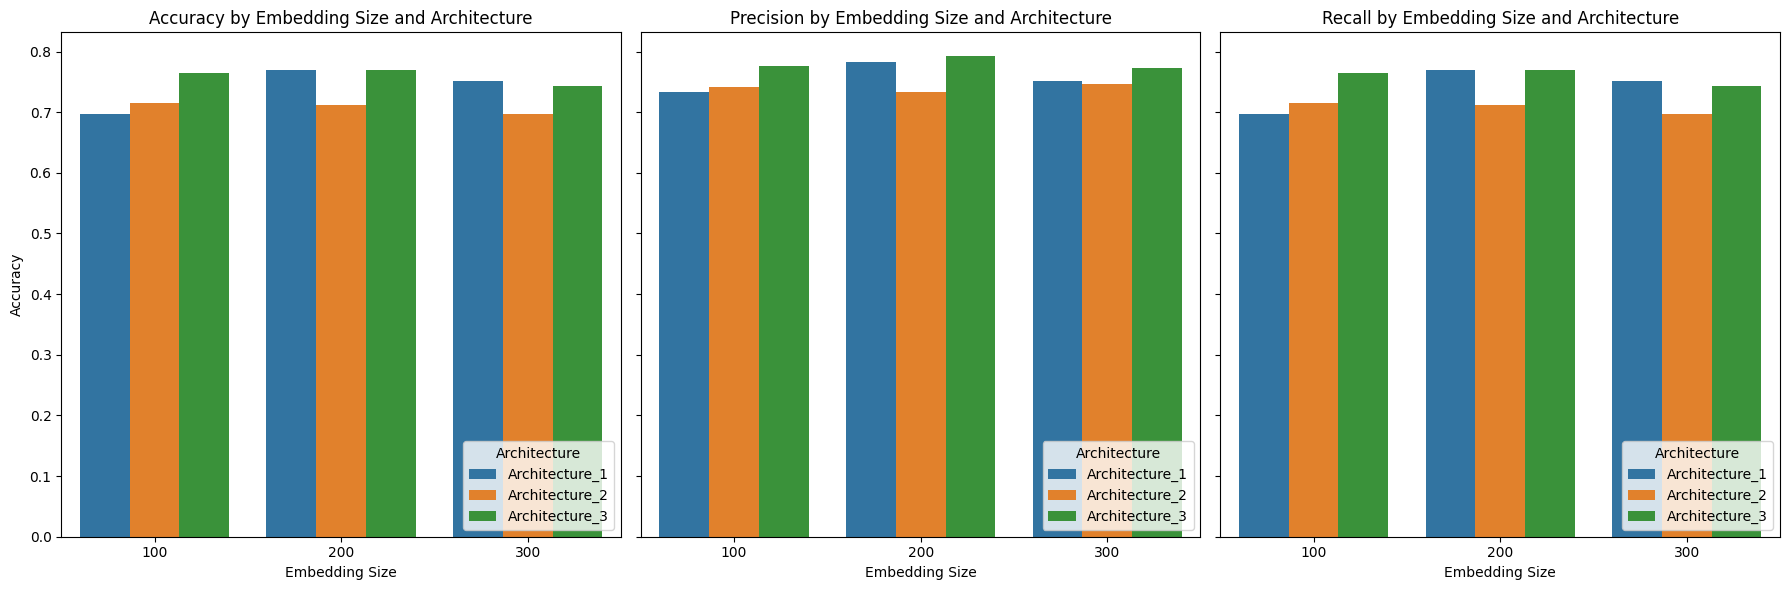

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, metric in enumerate(metrics):
    sns.barplot(x="Embedding Size", y=metric, hue="Architecture", data=results_df, ax=axes[i])
    axes[i].set_title(f'{metric} by Embedding Size and Architecture')
    axes[i].set_xlabel('Embedding Size')
    axes[i].legend(title='Architecture', loc='lower right')

plt.tight_layout()
plt.show()

## Glove embeddings

In [37]:
import gensim.downloader

glove_wiki_gigaword_100 = gensim.downloader.load('glove-wiki-gigaword-100')
glove_wiki_gigaword_200 = gensim.downloader.load('glove-wiki-gigaword-200')
glove_wiki_gigaword_300 = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 128.1/128.1MB downloaded
[==================================================] 100.0% 252.1/252.1MB downloaded
[==================================================] 100.0% 376.1/376.1MB downloaded


In [38]:
def create_glove_embedding_matrix(glove_model, tokenizer, embedding_size):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_size))

    for word, idx in tokenizer.word_index.items():
        if word in glove_model:
            embedding_matrix[idx] = glove_model[word]

    return embedding_matrix

In [42]:
results_glove = {
    "Architecture": [],
    "Embedding Size": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": []
}

### Embeddings de tamaño 100

In [39]:
embedding_size = 100

#### Arquitectura 1

In [40]:
embedding_matrix = create_glove_embedding_matrix(glove_wiki_gigaword_100, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_1(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 250, 100)            │         901,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 25000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │       3,200,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,101,515 (15.65 MB)

 Trainable params: 3,200,515 (12.21 MB)

 Non-trainable params: 901,000 (3.44 MB)

In [44]:
model_name = "glove_Architecture_1_size_100"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_1")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9766 - loss: 0.1056
Epoch 1: val_accuracy improved from -inf to 0.69091, saving model to best_model_glove_Architecture_1_size_100.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9763 - loss: 0.1061 - val_accuracy: 0.6909 - val_loss: 0.8938
Epoch 2/20
25/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0279   
Epoch 2: val_accuracy improved from 0.69091 to 0.71273, saving model to best_model_glove_Architecture_1_size_100.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9972 - loss: 0.0277 - val_accuracy: 0.7127 - val_loss: 0.9068
Epoch 3/20
25/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0080 
Epoch 3: val_accuracy did not improve from 0.71273
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.6909 - val_loss: 0.9713
Epoch 4/20
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0028
Epoch 4: val_accuracy did n

#### Arquitectura 2

In [45]:
embedding_matrix = create_glove_embedding_matrix(glove_wiki_gigaword_100, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_2(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (None, 250, 100)            │         901,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 25000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │       6,400,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,334,539 (27.98 MB)

 Trainable params: 6,433,539 (24.54 MB)

 Non-trainable params: 901,000 (3.44 MB)

In [46]:
model_name = "glove_Architecture_2_size_100"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_2")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5257 - loss: 0.9611
Epoch 1: val_accuracy improved from -inf to 0.65818, saving model to best_model_glove_Architecture_2_size_100.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.5278 - loss: 0.9583 - val_accuracy: 0.6582 - val_loss: 0.7497
Epoch 2/20
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9463 - loss: 0.2357
Epoch 2: val_accuracy improved from 0.65818 to 0.70909, saving model to best_model_glove_Architecture_2_size_100.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9459 - loss: 0.2326 - val_accuracy: 0.7091 - val_loss: 0.8084
Epoch 3/20
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9950 - loss: 0.0457
Epoch 3: val_accuracy did not improve from 0.70909
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9947 - loss: 0.0453 - val_accuracy: 0.6945 - val_loss: 1.1981
Epoch 4/20
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0191
Epoch 4: val_accuracy improved

#### Arquitectura 3

In [47]:
embedding_matrix = create_glove_embedding_matrix(glove_wiki_gigaword_100, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_3(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ (None, 250, 100)            │         901,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 25000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 512)                 │      12,800,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,833,611 (52.77 MB)

 Trainable params: 12,932,611 (49.33 MB)

 Non-trainable params: 901,000 (3.44 MB)

In [48]:
model_name = "glove_Architecture_3_size_100"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_3")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5498 - loss: 0.9611
Epoch 1: val_accuracy improved from -inf to 0.66909, saving model to best_model_glove_Architecture_3_size_100.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.5515 - loss: 0.9581 - val_accuracy: 0.6691 - val_loss: 0.7753
Epoch 2/20
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9167 - loss: 0.2598
Epoch 2: val_accuracy improved from 0.66909 to 0.70182, saving model to best_model_glove_Architecture_3_size_100.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9179 - loss: 0.2550 - val_accuracy: 0.7018 - val_loss: 0.7813
Epoch 3/20
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0298
Epoch 3: val_accuracy improved from 0.70182 to 0.73818, saving model to best_model_glove_Architecture_3_size_100.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9999 - loss: 0.0288 - val_accuracy: 0.7382 - val_loss: 0.9466
Epoch 4/20
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

### Embeddings de tamaño 200

In [49]:
embedding_size = 200

#### Arquitectura 1

In [50]:
embedding_matrix = create_glove_embedding_matrix(glove_wiki_gigaword_200, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_1(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ (None, 250, 200)            │       1,802,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 50000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │       6,400,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,202,515 (31.29 MB)

 Trainable params: 6,400,515 (24.42 MB)

 Non-trainable params: 1,802,000 (6.87 MB)

In [51]:
model_name = "glove_Architecture_1_size_200"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_1")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5474 - loss: 0.8993
Epoch 1: val_accuracy improved from -inf to 0.69091, saving model to best_model_glove_Architecture_1_size_200.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5499 - loss: 0.8963 - val_accuracy: 0.6909 - val_loss: 0.6913
Epoch 2/20
30/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9854 - loss: 0.1193
Epoch 2: val_accuracy improved from 0.69091 to 0.70909, saving model to best_model_glove_Architecture_1_size_200.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9842 - loss: 0.1127 - val_accuracy: 0.7091 - val_loss: 0.7408
Epoch 3/20
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9925 - loss: 0.0432
Epoch 3: val_accuracy improved from 0.70909 to 0.72727, saving model to best_model_glove_Architecture_1_size_200.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9925 - loss: 0.0430 - val_accuracy: 0.7273 - val_loss: 0.7583
Epoch 4/20
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

#### Arquitectura 2

In [52]:
embedding_matrix = create_glove_embedding_matrix(glove_wiki_gigaword_200, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_2(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)             │ (None, 250, 200)            │       1,802,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 50000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 256)                 │      12,800,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,635,539 (55.83 MB)

 Trainable params: 12,833,539 (48.96 MB)

 Non-trainable params: 1,802,000 (6.87 MB)

In [53]:
model_name = "glove_Architecture_2_size_200"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_2")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5611 - loss: 0.9479
Epoch 1: val_accuracy improved from -inf to 0.70545, saving model to best_model_glove_Architecture_2_size_200.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.5633 - loss: 0.9442 - val_accuracy: 0.7055 - val_loss: 0.6933
Epoch 2/20
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9563 - loss: 0.1592
Epoch 2: val_accuracy improved from 0.70545 to 0.74909, saving model to best_model_glove_Architecture_2_size_200.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9566 - loss: 0.1577 - val_accuracy: 0.7491 - val_loss: 0.8014
Epoch 3/20
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9981 - loss: 0.0155
Epoch 3: val_accuracy did not improve from 0.74909
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9980 - loss: 0.0157 - val_accuracy: 0.7418 - val_loss: 0.7919
Epoch 4/20
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0065
Epoch 4: val_accuracy impr

#### Arquitectura 3

In [54]:
embedding_matrix = create_glove_embedding_matrix(glove_wiki_gigaword_200, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_3(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ (None, 250, 200)            │       1,802,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 50000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 512)                 │      25,600,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,534,611 (105.04 MB)

 Trainable params: 25,732,611 (98.16 MB)

 Non-trainable params: 1,802,000 (6.87 MB)

In [55]:
model_name = "glove_Architecture_3_size_200"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_3")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5052 - loss: 1.0120
Epoch 1: val_accuracy improved from -inf to 0.63636, saving model to best_model_glove_Architecture_3_size_200.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - accuracy: 0.5079 - loss: 1.0078 - val_accuracy: 0.6364 - val_loss: 0.8041
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9542 - loss: 0.1748
Epoch 2: val_accuracy improved from 0.63636 to 0.74909, saving model to best_model_glove_Architecture_3_size_200.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 324ms/step - accuracy: 0.9543 - loss: 0.1738 - val_accuracy: 0.7491 - val_loss: 0.7074
Epoch 3/20
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9961 - loss: 0.0175
Epoch 3: val_accuracy did not improve from 0.74909
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9961 - loss: 0.0173 - val_accuracy: 0.7200 - val_loss: 0.9256
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0033
Epoch 4: val_accuracy did 

### Embeddings de tamaño 300

In [56]:
embedding_size = 300

#### Arquitectura 1

In [57]:
embedding_matrix = create_glove_embedding_matrix(glove_wiki_gigaword_300, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_1(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)             │ (None, 250, 300)            │       2,703,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 75000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 128)                 │       9,600,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,303,515 (46.93 MB)

 Trainable params: 9,600,515 (36.62 MB)

 Non-trainable params: 2,703,000 (10.31 MB)

In [58]:
model_name = "glove_Architecture_1_size_300"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_1")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5818 - loss: 0.8915
Epoch 1: val_accuracy improved from -inf to 0.72364, saving model to best_model_glove_Architecture_1_size_300.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.5838 - loss: 0.8882 - val_accuracy: 0.7236 - val_loss: 0.6387
Epoch 2/20
30/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9915 - loss: 0.0632
Epoch 2: val_accuracy improved from 0.72364 to 0.76364, saving model to best_model_glove_Architecture_1_size_300.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9925 - loss: 0.0586 - val_accuracy: 0.7636 - val_loss: 0.6506
Epoch 3/20
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0084
Epoch 3: val_accuracy did not improve from 0.76364
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 0.7564 - val_loss: 0.7055
Epoch 4/20
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0040
Epoch 4: val_accuracy did not

#### Arquitectura 2

In [59]:
embedding_matrix = create_glove_embedding_matrix(glove_wiki_gigaword_300, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_2(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)             │ (None, 250, 300)            │       2,703,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 75000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 256)                 │      19,200,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,936,539 (83.68 MB)

 Trainable params: 19,233,539 (73.37 MB)

 Non-trainable params: 2,703,000 (10.31 MB)

In [60]:
model_name = "glove_Architecture_2_size_300"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_2")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5994 - loss: 0.8658
Epoch 1: val_accuracy improved from -inf to 0.73091, saving model to best_model_glove_Architecture_2_size_300.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.6010 - loss: 0.8634 - val_accuracy: 0.7309 - val_loss: 0.6457
Epoch 2/20
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9901 - loss: 0.0744
Epoch 2: val_accuracy improved from 0.73091 to 0.75273, saving model to best_model_glove_Architecture_2_size_300.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9903 - loss: 0.0726 - val_accuracy: 0.7527 - val_loss: 0.7601
Epoch 3/20
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0077
Epoch 3: val_accuracy did not improve from 0.75273
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.7455 - val_loss: 0.8761
Epoch 4/20
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 4: val_accuracy di

#### Arquitectura 3

In [61]:
embedding_matrix = create_glove_embedding_matrix(glove_wiki_gigaword_300, tokenizer, embedding_size)
vocab_size = len(tokenizer.word_index) + 1
model = create_model_architecture_3(embedding_matrix, vocab_size, embedding_size)
model.build(input_shape=(None, 250))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)             │ (None, 250, 300)            │       2,703,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 75000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 512)                 │      38,400,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,235,611 (157.30 MB)

 Trainable params: 38,532,611 (146.99 MB)

 Non-trainable params: 2,703,000 (10.31 MB)

In [62]:
model_name = "glove_Architecture_3_size_300"
history = train_model(model, (X_train, y_train), (X_val, y_val), model_name)
accuracy, precision, recall = evaluate_model(model, (X_test, y_test))
results_glove["Architecture"].append("Architecture_3")
results_glove["Embedding Size"].append(embedding_size)
results_glove["Accuracy"].append(accuracy)
results_glove["Precision"].append(precision)
results_glove["Recall"].append(recall)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5566 - loss: 0.9223
Epoch 1: val_accuracy improved from -inf to 0.74182, saving model to best_model_glove_Architecture_3_size_300.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 364ms/step - accuracy: 0.5590 - loss: 0.9191 - val_accuracy: 0.7418 - val_loss: 0.6036
Epoch 2/20
36/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9841 - loss: 0.1016
Epoch 2: val_accuracy improved from 0.74182 to 0.76364, saving model to best_model_glove_Architecture_3_size_300.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 235ms/step - accuracy: 0.9848 - loss: 0.0963 - val_accuracy: 0.7636 - val_loss: 0.7322
Epoch 3/20
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0028
Epoch 3: val_accuracy did not improve from 0.76364
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.7636 - val_loss: 0.8406
Epoch 4/20
36/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.0337e-04
Epoch 4: val_accuracy

#### Resultados

In [63]:
glove_results_df = pd.DataFrame(results_glove)
glove_results_df

,Architecture,Embedding Size,Accuracy,Precision,Recall
0,Architecture_1,100,0.678700,0.668188,0.678700
1,Architecture_2,100,0.657040,0.670777,0.657040
2,Architecture_3,100,0.678700,0.670385,0.678700
3,Architecture_1,200,0.696751,0.694981,0.696751
4,Architecture_2,200,0.700361,0.692752,0.700361
5,Architecture_3,200,0.678700,0.670645,0.678700
6,Architecture_1,300,0.740072,0.740950,0.740072
7,Architecture_2,300,0.696751,0.690176,0.696751
8,Architecture_3,300,0.725632,0.722141,0.725632


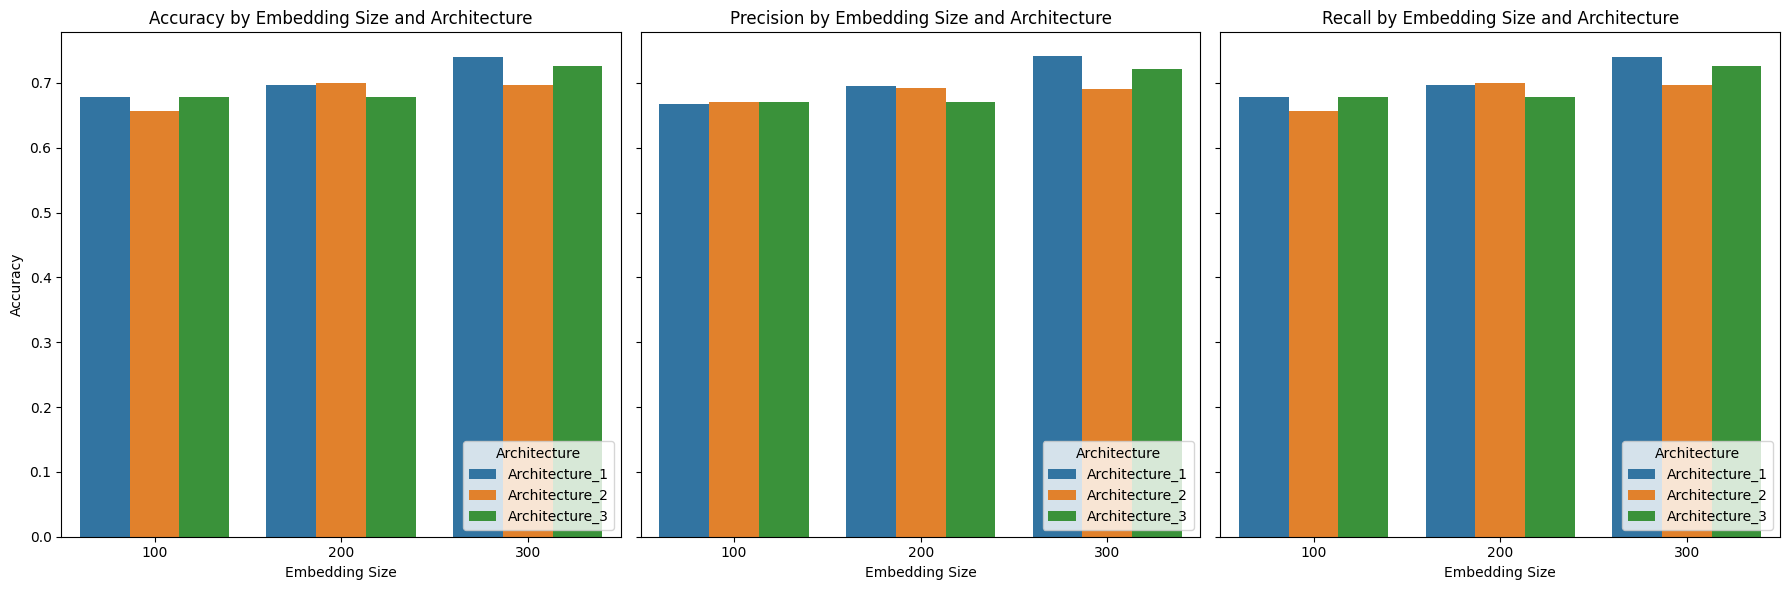

In [64]:
metrics = ["Accuracy", "Precision", "Recall"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, metric in enumerate(metrics):
    sns.barplot(x="Embedding Size", y=metric, hue="Architecture", data=glove_results_df, ax=axes[i])
    axes[i].set_title(f'{metric} by Embedding Size and Architecture')
    axes[i].set_xlabel('Embedding Size')
    axes[i].legend(title='Architecture', loc='lower right')

plt.tight_layout()
plt.show()